In [1]:
import os
import sys

# sys.prefix в виртуальном окружении указывает на его корень
os.chdir(os.path.dirname(sys.prefix))

print(f"Рабочая директория: {os.getcwd()}")


Рабочая директория: d:\code-files\diplom


# Библиотеки

In [2]:
import cv2
import pymupdf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import (
    CubicSpline, RegularGridInterpolator
)

## 1. Определение границ области текста (**boundary box**) у страницы **pdf** файла

### 1.1 Загрузка **pdf**, страницы

In [2]:
doc = pymupdf.open("../data/pdfs/BasicLatex_MEPhI.pdf")
page_number = 100 - 1
page = doc[page_number]
is_rotated = abs(page.rotation) in [90, 270] or page.rect.width > page.rect.height
print("Is landscape (rotated 90 degrees):", is_rotated)

Is landscape (rotated 90 degrees): False


### 1.2 Определяем **boundary box**

In [3]:
words = page.get_text("words")

x0 = min(b[0] for b in words)
y0 = min(b[1] for b in words)
x1 = max(b[2] for b in words)
y1 = max(b[3] for b in words)

text_bbox = (x0, y0, x1, y1)
text_bbox

(49.60599899291992, 20.379100799560547, 371.86419677734375, 523.358154296875)

In [4]:
# проверка, какими словами начинается и заканчивается страница
num_words  = 5
start_text = [word[4] for word in words[0:num_words]]
end_text   = [word[4] for word in words[-(num_words+1):-1]]
start_text, end_text

(['100', 'ВЕРСТКА', 'ФОРМУЛ', 'ГЛ.', '4'],
 ['—', 'математические', 'выражения', 'или', 'текст.'])

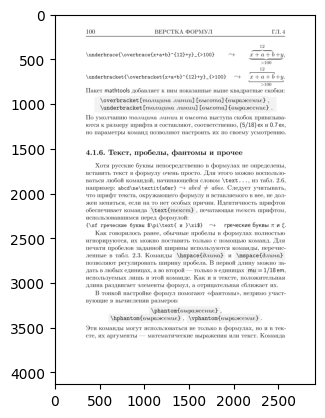

In [5]:
pix = page.get_pixmap(dpi=500)
pix.save("page.png")

img_rgb = np.array(Image.open("page.png").convert("RGB"))
plt.imshow(img_rgb)

### 1.3 Переход от системы координат **pdf** (*пункты*) к **png** (*пиксели*) 

In [6]:
width_pt  = page.rect.width
height_pt = page.rect.height

width_px  = pix.width
height_px = pix.height

sx = width_px  / width_pt
sy = height_px / height_pt

def pdf_to_image_coords(x, y):
    x_px = x * sx
    y_px = y * sy
    return int(x_px), int(y_px)

In [7]:
x0_px, y1_px = pdf_to_image_coords(x0, y0)
x1_px, y0_px = pdf_to_image_coords(x1, y1)

[ (x0_px, y0_px), (x1_px, y1_px) ]

[(344, 3634), (2582, 141)]

### 1.4 Отображение **boundary box** текста

In [8]:
img = cv2.imread("page.png")
if is_rotated:
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

cv2.rectangle(
    img,
    (x0_px, y0_px),
    (x1_px, y1_px),
    (0, 0, 255),  # красный
    3             # толщина
)

cv2.imwrite("page_with_bbox.png", img)

True

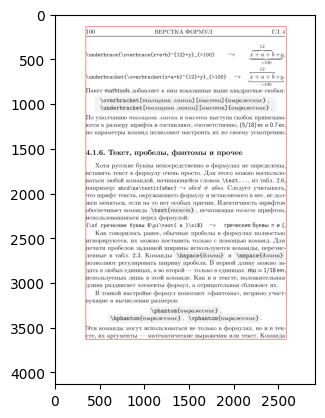

In [9]:
img = Image.open("page_with_bbox.png").convert("RGB")
plt.imshow(img)

## 2. Пайплайн искривления изображения

### 2.1 Загрузка **pdf**, страницы

In [10]:
doc = pymupdf.open("../data/pdfs/BasicLatex_MEPhI.pdf")
page_number = 100 - 1
page = doc[page_number]
is_rotated = abs(page.rotation) in [90, 270] or page.rect.width > page.rect.height
print("Is landscape (rotated 90 degrees):", is_rotated)

Is landscape (rotated 90 degrees): False


In [11]:
pix = page.get_pixmap(dpi=500)
pix.save("test.png")

4134 2914


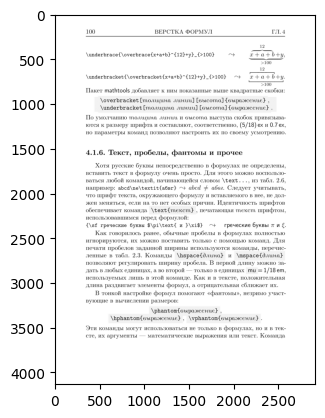

In [12]:
img = cv2.imread("test.png", cv2.IMREAD_GRAYSCALE)
assert img is not None

H, W = img.shape
print(H, W)

plt.imshow(img, cmap="gray")
# plt.axis("off")

### 2.2 Генерация граничных точек **по краю изображения**

In [13]:
def generate_border_points(W, H, n=20):
    xs = np.linspace(0, W - 1, n)
    ys = np.linspace(0, H - 1, n)

    top = np.stack([xs, np.zeros_like(xs)], axis=1)
    bottom = np.stack([xs, np.full_like(xs, H - 1)], axis=1)
    left = np.stack([np.zeros_like(ys), ys], axis=1)
    right = np.stack([np.full_like(ys, W - 1), ys], axis=1)

    return top, bottom, left, right

(np.float64(-0.5), np.float64(2913.5), np.float64(4133.5), np.float64(-0.5))

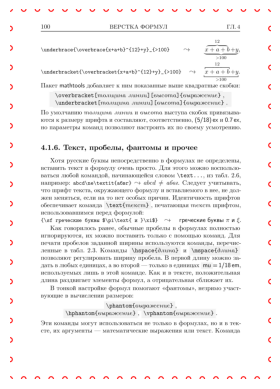

In [14]:
top, bottom, left, right = generate_border_points(W, H)

vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for p in np.vstack([top, bottom, left, right]):
    cv2.circle(img=vis, 
               center=tuple(p.astype(int)), 
               radius=25, color=(255,0,0), thickness=10)

plt.imshow(vis)
plt.axis("off")

### 2.3 Простейшая волнообразная деформация

In [15]:
def warp_points(points, axis="y", amp=20, freq=2):
    warped = points.copy()
    if axis == "y":
        warped[:, 1] += amp * np.sin(2 * np.pi * points[:, 0] / W * freq)
    else:
        warped[:, 0] += amp * np.sin(2 * np.pi * points[:, 1] / H * freq)
    return warped

In [16]:
top_w    = warp_points(top, "y", amp=30)
bottom_w = warp_points(bottom, "y", amp=30)
left_w   = warp_points(left, "x", amp=20)
right_w  = warp_points(right, "x", amp=20)

(np.float64(-0.5), np.float64(2913.5), np.float64(4133.5), np.float64(-0.5))

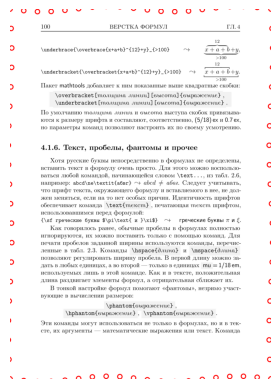

In [17]:
vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for p in np.vstack([top_w, bottom_w, left_w, right_w]):
    cv2.circle(img=vis, 
               center=tuple(p.astype(int)), 
               radius=25, color=(255,0,0), thickness=10)

plt.imshow(vis)
plt.axis("off")

### 2.4 Построение mesh grid

In [18]:
def preprocess_edges(edge_top, edge_bottom, edge_left, edge_right):
    # 1. Сортировка top и bottom по X
    edge_top = sorted(edge_top, key=lambda p: p[0])
    edge_bottom = sorted(edge_bottom, key=lambda p: p[0])

    # 2. Сортировка left и right по Y
    edge_left = sorted(edge_left, key=lambda p: p[1], reverse=True)
    edge_right = sorted(edge_right, key=lambda p: p[1], reverse=True)

    # 3. Приведение к согласованным крайним точкам
    is_equal = np.array_equal
    # TL (top-left)
    tl = edge_top[0]
    if is_equal(edge_left[-1], tl):
        edge_left.append(tl)

    # TR (top-right)
    tr = edge_top[-1]
    if is_equal(edge_right[-1], tr):
        edge_right.append(tr)

    # BL (bottom-left)
    bl = edge_bottom[0]
    if is_equal(edge_left[0], bl):
        edge_left.insert(0, bl)

    # BR (bottom-right)
    br = edge_bottom[-1]
    if is_equal(edge_right[0], br):
        edge_right.insert(0, br)

    return edge_top, edge_bottom, edge_left, edge_right

In [19]:
def create_natural_spline(points: list[tuple|list[float, float]]):
    """Создает натурально-параметризованный кубический сплайн"""
    points = np.array(points)
    
    # Проверка на пустые входные данные
    if len(points) < 2:
        raise ValueError("Для создания сплайна нужно минимум 2 точки")
    
    # Вычисление параметрического расстояния между точками
    diffs = np.diff(points, axis=0)
    distances = np.sqrt(np.sum(diffs**2, axis=1))
    t = np.insert(np.cumsum(distances), 0, 0)
    t_normalized = t / t[-1] if t[-1] != 0 else t
    
    # Проверка на дубликаты и близкие значения параметра
    eps = 1e-10
    unique_indices = [0]
    
    for i in range(1, len(t_normalized)):
        if t_normalized[i] - t_normalized[unique_indices[-1]] > eps:
            unique_indices.append(i)
    
    # Используем только уникальные значения
    t_unique = t_normalized[unique_indices]
    points_unique = points[unique_indices]
    
    # Если осталось менее 2 уникальных точек, не можем построить сплайн
    if len(t_unique) < 2:
        # Возвращаем линейную интерполяцию (константу) в этом случае
        def constant_func(t):
            if np.isscalar(t):
                return np.array([points[0]])
            return np.array([points[0]] * len(t))
        return constant_func
    
    # Построение сплайнов для координат x и y
    cs_x = CubicSpline(t_unique, points_unique[:, 0], bc_type='natural')
    cs_y = CubicSpline(t_unique, points_unique[:, 1], bc_type='natural')

    def spline_func(t):
        x = cs_x(t)
        y = cs_y(t)
        # Обработка разных случаев входных данных
        if np.isscalar(t):
            # Скаляр - возвращаем массив формы (1, 2)
            return np.array([[x, y]])
        elif np.ndim(x) == 1:
            # 1D массив - используем column_stack
            return np.column_stack([x, y])
        else:
            # Многомерный массив - используем stack по последней оси
            return np.stack([x, y], axis=-1)

    return spline_func

In [20]:
def build_mesh_function(edge_top, edge_bottom, edge_left, edge_right):
    """Возвращает функцию mesh_point(s, t)"""
    spline_top = create_natural_spline(edge_top)
    spline_bottom = create_natural_spline(edge_bottom)
    spline_left = create_natural_spline(edge_left)
    spline_right = create_natural_spline(edge_right)

    # Извлекаем угловые точки как 1D массивы для правильного broadcasting
    P00 = np.array(spline_bottom(0)).flatten()  # Левый нижний
    P10 = np.array(spline_bottom(1)).flatten()  # Правый нижний
    P01 = np.array(spline_top(0)).flatten()     # Левый верхний
    P11 = np.array(spline_top(1)).flatten()     # Правый верхний

    def mesh_point(s, t):
        # Вычисляем результаты сплайнов
        bottom_pts = spline_bottom(s)
        top_pts = spline_top(s)
        left_pts = spline_left(t)
        right_pts = spline_right(t)
        
        # Правильное broadcasting для term1 и term2
        # Если s и t - массивы, добавляем новую ось для broadcasting
        if np.ndim(s) > 0 or np.ndim(t) > 0:
            # s и t - массивы
            term1 = (1-t)[..., np.newaxis]*bottom_pts + t[..., np.newaxis]*top_pts
            term2 = (1-s)[..., np.newaxis]*left_pts + s[..., np.newaxis]*right_pts
            # Правильное broadcasting для term3
            term3 = (1-t)[..., np.newaxis]*(1-s)[..., np.newaxis]*P00 + \
                    (1-t)[..., np.newaxis]*s[..., np.newaxis]*P10 + \
                    t[..., np.newaxis]*(1-s)[..., np.newaxis]*P01 + \
                    t[..., np.newaxis]*s[..., np.newaxis]*P11
        else:
            # s и t - скаляры
            term1 = (1-t)*bottom_pts + t*top_pts
            term2 = (1-s)*left_pts + s*right_pts
            term3 = (1-t)*(1-s)*P00 + (1-t)*s*P10 + t*(1-s)*P01 + t*s*P11
        return term1 + term2 - term3

    return mesh_point

In [21]:
def compute_remap_maps(mesh_func, normalized_grid):
    res = mesh_func(normalized_grid[..., 1], normalized_grid[..., 0])
    map_y = res[..., 1]
    map_x = res[..., 0]
    map_x = map_x.astype(np.float32)
    map_y = map_y.astype(np.float32)
    return map_x, map_y

In [22]:
def apply_remap(image, map_x, map_y, interpolation=cv2.INTER_CUBIC,
                border_mode=cv2.BORDER_CONSTANT, border_value=None):
    result = cv2.remap(image,
                      map_x,
                      map_y,
                      interpolation=interpolation,
                      borderMode=border_mode,
                      borderValue=border_value)
    return result

In [23]:
def create_coordinate_grid(height, width):
    grid = np.mgrid[height-1:-1:-1, 0:width:1].swapaxes(0, 2).swapaxes(0, 1)
    return grid

def normalize_grid_coordinates(grid, width, height):
    normalized_grid = grid.copy().astype(np.float32)
    grid = grid.copy().astype(np.float32)
    normalized_grid[..., 1] /= (width-1)  # s coordinate (horizontal)
    normalized_grid[..., 0] /= (height-1)  # t coordinate (vertical)
    return normalized_grid

In [24]:
# Путь к изображению, которое будем выравнивать
image_path = "test.png"

# Граничные точки от пользователя или сгенерированные
edge_points_lists = {
    "edge_top":    top_w, 
    "edge_bottom": bottom_w,
    "edge_left":   left_w, 
    "edge_right":  right_w
}

image = cv2.imread(image_path)

height, width = image.shape[:2]
grid = create_coordinate_grid(height, width)

normalized_grid = normalize_grid_coordinates(grid, width, height)

prep_edge_top, prep_edge_bottom, prep_edge_left, prep_edge_right = preprocess_edges(**edge_points_lists)

mesh_func = build_mesh_function(prep_edge_top, prep_edge_bottom, prep_edge_left, prep_edge_right)

map_x, map_y = compute_remap_maps(mesh_func, normalized_grid)

warped = apply_remap(image, map_x, map_y,
                     border_mode=cv2.BORDER_CONSTANT,
                     border_value=(255,255,255) # БЕЛЫЙ фон
                )

(np.float64(-0.5), np.float64(2913.5), np.float64(4133.5), np.float64(-0.5))

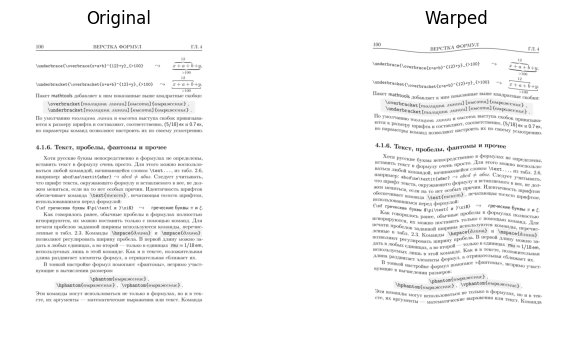

In [25]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Warped")
plt.imshow(warped, cmap="gray")
plt.axis("off")

### 2.5 Вычисление обратного **remap**

In [26]:
from scipy.interpolate import griddata

def invert_remap_griddata(map_x, map_y):
    H, W = map_x.shape

    src = np.stack([map_x.ravel(), map_y.ravel()], axis=1)
    dst = np.stack(np.meshgrid(np.arange(W), np.arange(H)), axis=-1).reshape(-1,2)

    inv_x = griddata(src, dst[:,0], src, method='linear')
    inv_y = griddata(src, dst[:,1], src, method='linear')

    return inv_x.reshape(H,W), inv_y.reshape(H,W)

In [27]:
def invert_remap_fast(map_x, map_y):
    """
    Быстрое вычисление обратного remap.
    map_x, map_y: float32, shape (H, W)
    """
    H, W = map_x.shape

    inv_x = np.full((H, W), -1, dtype=np.float32)
    inv_y = np.full((H, W), -1, dtype=np.float32)

    # исходная регулярная сетка
    grid_y, grid_x = np.meshgrid(
        np.arange(H),
        np.arange(W),
        indexing="ij"
    )

    # округляем координаты назначения
    xs = np.round(map_x).astype(np.int32)
    ys = np.round(map_y).astype(np.int32)

    # маска валидных координат
    valid = (
        (xs >= 0) & (xs < W) &
        (ys >= 0) & (ys < H)
    )

    # scatter
    inv_x[ys[valid], xs[valid]] = grid_x[valid]
    inv_y[ys[valid], xs[valid]] = grid_y[valid]

    # маска дыр
    mask = (inv_x < 0).astype(np.uint8)

    # заполнение дыр
    inv_x = cv2.inpaint(inv_x, mask, 3, cv2.INPAINT_NS)
    inv_y = cv2.inpaint(inv_y, mask, 3, cv2.INPAINT_NS)

    return inv_x, inv_y


In [32]:
inv_map_x, inv_map_y = invert_remap_fast(map_x, map_y)

In [33]:
restored = apply_remap(warped, inv_map_x, inv_map_y,
                     border_mode=cv2.BORDER_CONSTANT,
                     border_value=(255,255,255) # БЕЛЫЙ фон
                )

(np.float64(-0.5), np.float64(2913.5), np.float64(4133.5), np.float64(-0.5))

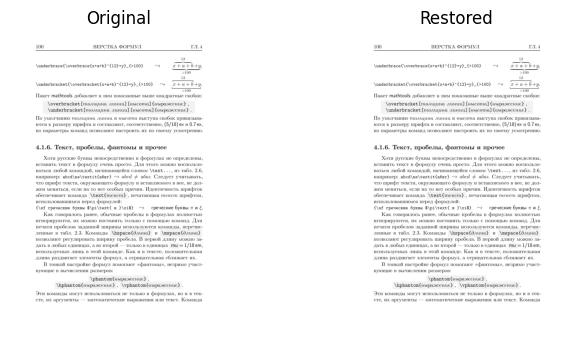

In [34]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Restored")
plt.imshow(restored, cmap="gray")
plt.axis("off")

In [38]:
cv2.imwrite("warped.png", warped), cv2.imwrite("restored.png", restored)

(True, True)

## 3. **Pdf**-to-**Image**

In [33]:
import random
from tqdm import trange

In [34]:
doc = pymupdf.open("data/pdf/BasicLatex_MEPhI.pdf")
doc

Document('data/pdf/BasicLatex_MEPhI.pdf')

In [35]:
name_temp = "latex_{:03d}.png"

In [37]:
random.seed(52)
for idx, pg_num in enumerate(trange(5, 305), start=1):
    page = doc[pg_num]
    # Случайно выбрать целое от 100 до 200, чаще ближе к 100 (распределение экспоненциальное сдвинутое)
    dpi = int(100 + random.expovariate(1/20))
    dpi = min(dpi, 200)
    pix = page.get_pixmap(dpi=dpi)
    name = name_temp.format(idx)
    save_path = os.path.join('data' ,'raw', 'v1', name)
    pix.save(save_path)

100%|██████████| 300/300 [00:14<00:00, 21.16it/s]
